# Experiments for image encoding evaluation

## Setup

### Google Drive setup

In [90]:
import os
from pathlib import Path

GEQIE_PATH = Path(os.getcwd()).parent
WORK_DIR = Path(".")  # directory for logs and outputs, overridden in Colab scenario

DRIVE_MOUNT_PATH = Path("/content/drive")
_DRIVE_WORK_DIR = DRIVE_MOUNT_PATH / "MyDrive" / "Colab Notebooks" / "GEQIE"  # overrides WORK_DIR in Colab

try:
    from google.colab import drive

    print("Environment is Google Colab.")
    WORK_DIR = _DRIVE_WORK_DIR

    GEQIE_PATH = Path("/content/geqie")
    print(f"GEQIE path set to '{GEQIE_PATH}'")

    print(f"Mounting Google Drive '{DRIVE_MOUNT_PATH}'...")
    drive.mount(DRIVE_MOUNT_PATH.as_posix())

    print("Installing dependencies...")

    ! git clone https://github.com/merQlab/geqie.git $GEQIE_PATH 2>/dev/null
    ! uv pip install $GEQIE_PATH 2>/dev/null
    ! uv pip install -r $GEQIE_PATH/experiments/requirements/requirements.in 2>/dev/null

    print("Dependencies installed successfully.")
except ModuleNotFoundError as e:
    print("Environment is not Google Colab... skipping.")
except Exception as e:
    print("Error encountered: " + str(e))

Environment is not Google Colab... skipping.


### Imports

In [91]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageOps
from tqdm import tqdm

import geqie
from geqie.encodings import frqi, ifrqi, mcqi, ncqi, neqr, qrci, qualpi

%matplotlib inline

### Constants

In [92]:
GRAYSCALE_PATH = GEQIE_PATH / "assets" / "test_images" / "grayscale"
GRAYSCALE_METHODS = [
    frqi,
    neqr,
]


RGB_PATH = GEQIE_PATH / "assets" / "test_images" / "rgb"
RGB_METHODS = [
    ifrqi,
    mcqi,
]

In [93]:
GRAYSCALE_IMAGE_PATHS = sorted(GRAYSCALE_PATH.glob("*.png"))
RGB_IMAGE_PATHS = sorted(RGB_PATH.glob("*.png"))

### Helpers

In [94]:
def plot_images_side_by_side(original, retrieved, title="", plot_inline=True):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    if title:
        fig.suptitle(title)

    axes[0].set_title('Original Image')
    axes[0].imshow(original, cmap='gray' if original.ndim == 2 else None)
    axes[0].axis('off')

    axes[1].set_title('Retrieved Image')
    axes[1].imshow(retrieved, cmap='gray' if retrieved.ndim == 2 else None)
    axes[1].axis('off')
    fig.tight_layout()

    if plot_inline:
        fig.show()
    else:
        plt.close(fig)
    return fig

## Experiment 1: Image Reconstruction Quality

In [95]:
image_plots = {}
for (method, image_path) in tqdm(list(product(GRAYSCALE_METHODS, GRAYSCALE_IMAGE_PATHS))):
    image = Image.open(image_path)
    image = ImageOps.grayscale(image)
    image = np.asarray(image)

    circuit = geqie.encode(method.init_function, method.data_function, method.map_function, image)
    result = geqie.simulate(circuit, 1024)
    retrieved_image = method.retrieve_function(result)

    image_plots[(method.__name__, image_path.name)] = plot_images_side_by_side(image, retrieved_image, title=f"{method.__name__}: {image_path.name}", plot_inline=False)

100%|██████████| 14/14 [00:45<00:00,  3.24s/it]


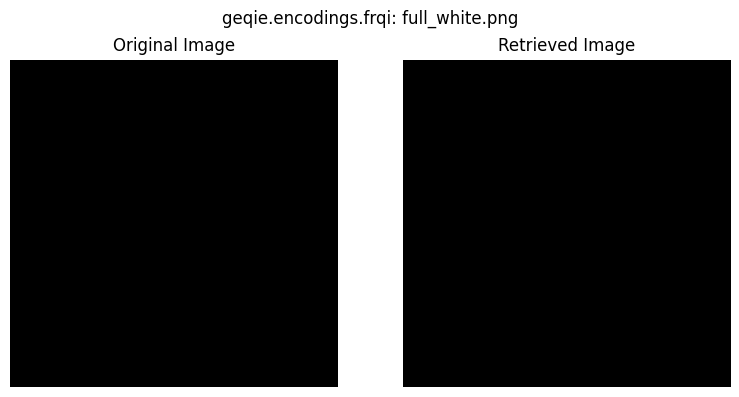

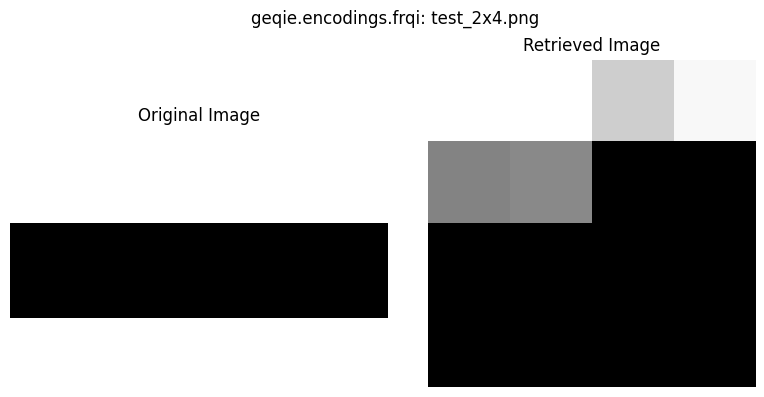

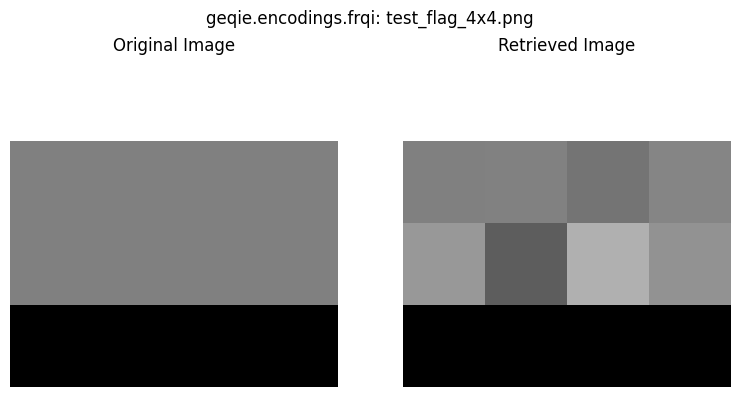

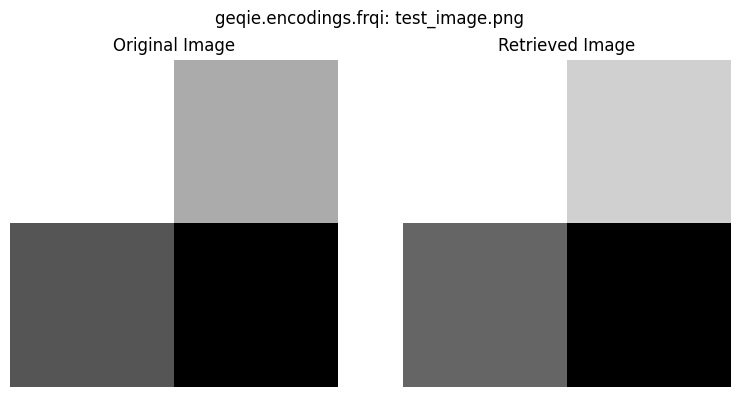

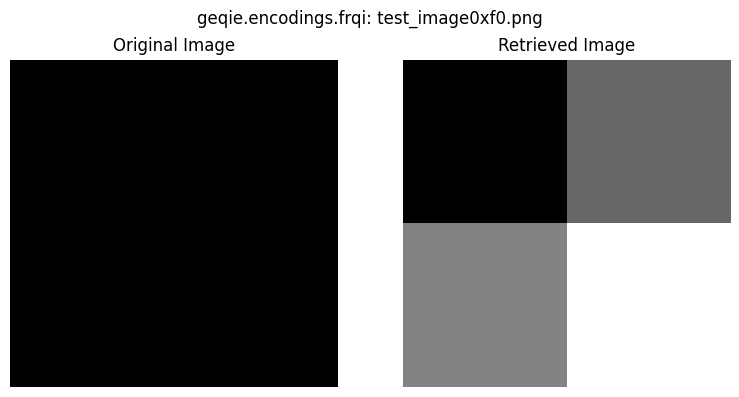

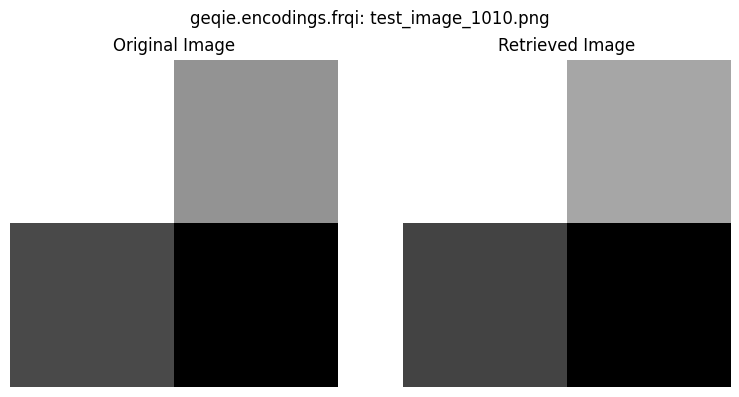

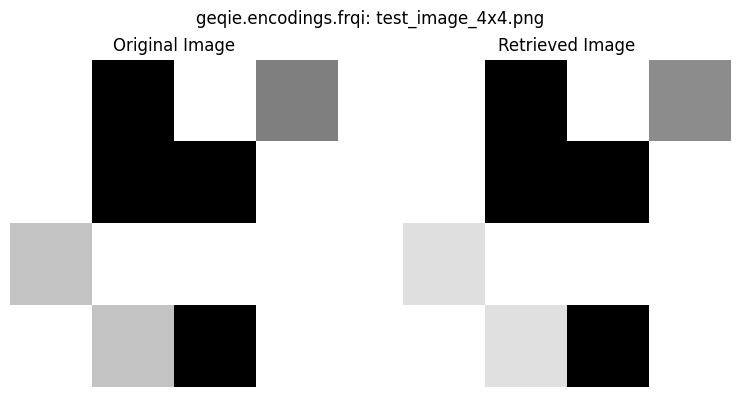

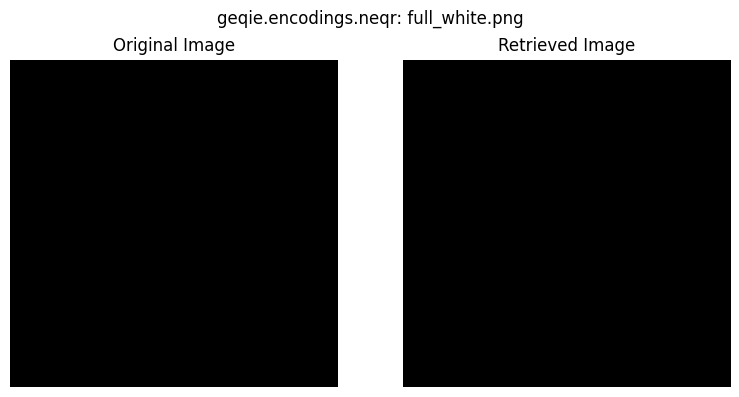

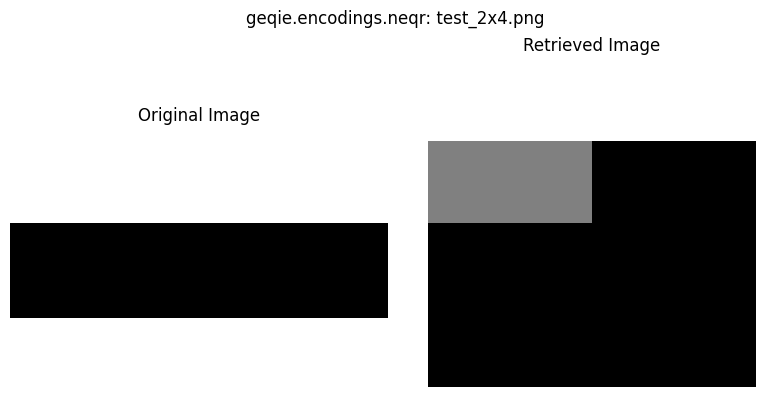

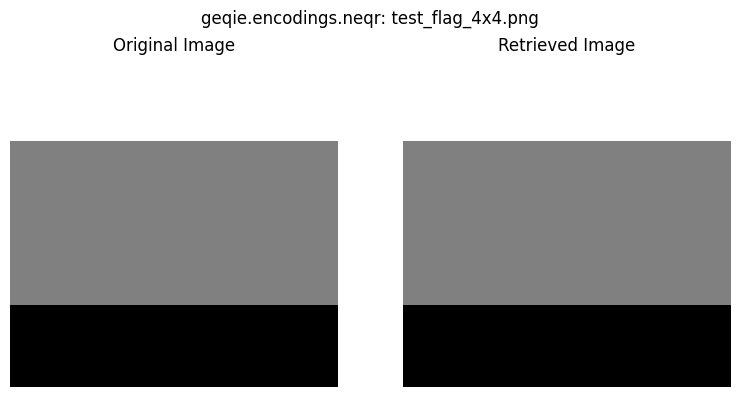

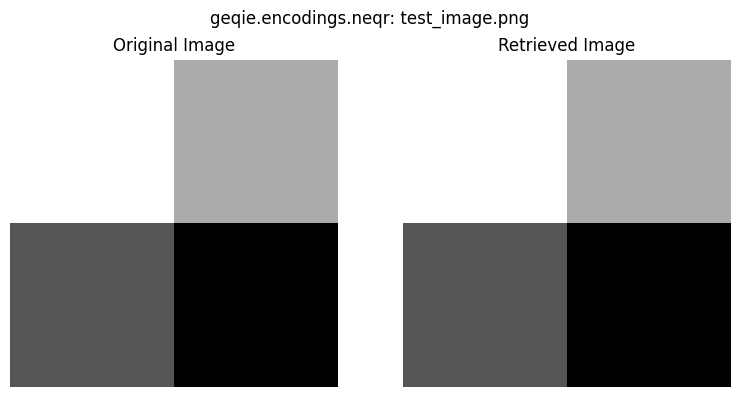

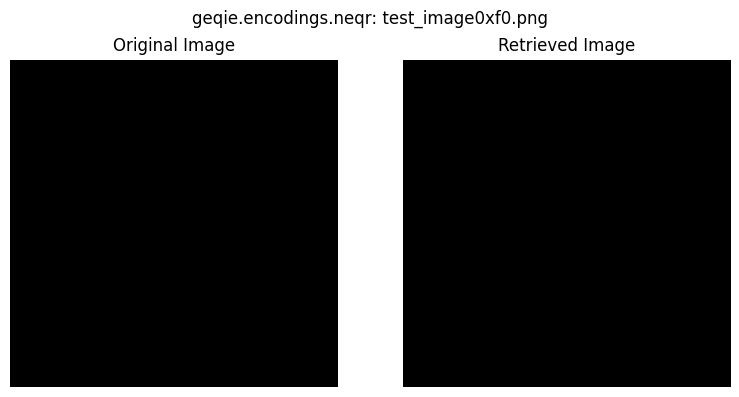

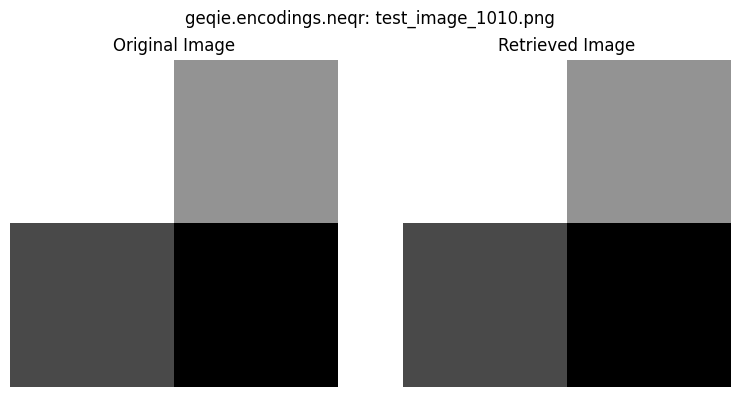

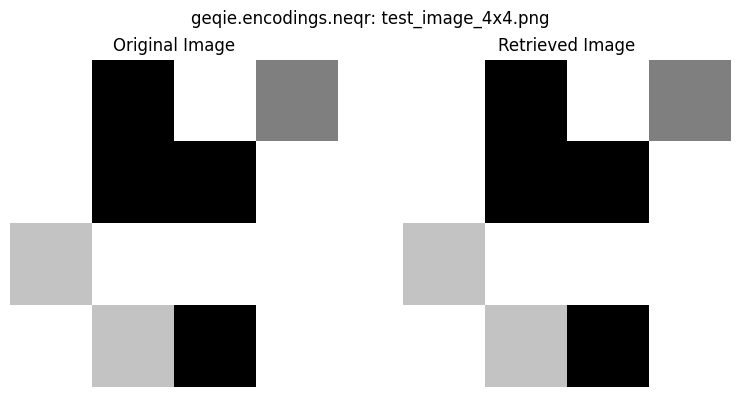

In [96]:
for fig in image_plots.values():
    display(fig)